# Convolution Neural Network (CNN) classification pipeline
(adapted from the work done by Erik Learned-Miller, which was originally developed by Fei-Fei Li, Andrej Karpathy, and Justin Johnson)

## Overview
<font size='4'> In this assignment you will practice putting together a Convolution Neural Network (CNN) classification pipeline. So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

<font size='4'>In this module, you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.
    
## Note: 
* <font size='4'>Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Failure to follow any of these instructions will lead to point deductions. 
* <font size='4'>We have some inline questions embedded in the Jupyter notebook files. Do not miss them.

## setup

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
# from utils.classifiers.fc_net import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver
from utils.layers import affine_forward, affine_backward, relu_forward, relu_backward, softmax_loss

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# let's download the data
%cd ../datasets

# 1 -- Linux 
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 3


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

D:\CS 5330\pa5_1\pa5_1\datasets


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  162M    1 2770k    0     0  2770k      0  0:01:00 --:--:--  0:01:00 2953k
 10  162M   10 16.8M    0     0  16.8M      0  0:00:09  0:00:01  0:00:08 8890k
 34  162M   34 55.7M    0     0  27.8M      0  0:00:05  0:00:02  0:00:03 18.9M
 57  162M   57 93.9M    0     0  31.3M      0  0:00:05  0:00:03  0:00:02 23.8M
 83  162M   83  136M    0     0  34.0M      0  0:00:04  0:00:04 --:--:-- 27.5M
100  162M  100  162M    0     0  32.5M      0  0:00:05  0:00:05 --:--:-- 33.5M
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/d

In [3]:
# Load the (preprocessed) CIFAR10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

data = get_CIFAR10_data(cifar10_dir)
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


## Part 1: Convolution layers

<font size="4" color="red">**task 1.1: forward pass of a convolution layer**

In [4]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.


    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None
    
    # TODO: Implement the convolutional forward pass.                         
    # Hint: you can use the function np.pad for padding.                      
    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    
    pad = conv_param['pad']
    stride = conv_param['stride']
    
    
    H1 = np.int(1 + ((H + 2 * pad - HH) / stride))
    W1 = np.int(1 + ((W + 2 * pad - WW) / stride))
    
    xpad = np.pad(x, ((0,0), (0,0), (pad,pad), (pad,pad)), 'constant')
    out = np.zeros([N, F, H1, W1])

    for nn in range(N):
        for ff in range(F):
            for hh in range(H1):
                for ww in range(W1):
                    out[nn,ff,hh,ww] = np.sum(xpad[nn, :, hh*stride:hh*stride+HH, ww*stride:ww*stride+WW] * w[ff,...]) + b[ff]
    
    cache = (x, w, b, conv_param)
    return out, cache

In [5]:
# check your forward pass implementation
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


<font size="4" color="red">**task 1.2: backward pass of a convolution layer**

In [6]:
def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    
    # TODO: Implement the convolutional backward pass.                        
    x, w, b, conv_param = cache
    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    
    pad = conv_param['pad']
    stride = conv_param['stride']

    xpad = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), 'constant')


    H1 = (H + 2 * pad - HH) // stride + 1 
    W1 = (W + 2 * pad - WW) // stride + 1


    dxpad = np.zeros_like(xpad)
    dx = np.zeros_like(x)
    dw = np.zeros_like(w)
    db = np.zeros_like(b)
    
    
    for nn in range(N): 
        for ff in range(F): 
            db[ff] += dout[nn, ff].sum() 
            for hh in range(0, H1): 
                for ww in range(0, W1): 
                    dw[ff] += xpad[nn, :, hh * stride:hh * stride + HH, ww * stride:ww * stride + WW] * dout[nn, ff, hh, ww]
                    dxpad[nn, :, hh * stride:hh * stride + HH, ww * stride:ww * stride + WW] += w[ff] * dout[nn, ff, hh, ww]
    
    dx = dxpad[:, :, pad:pad+H, pad:pad+W]
    
    return dx, dw, db

In [7]:
# gradient check
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.2471264748452487e-10
db error:  3.37264006649648e-11


## Part 2: Spatial Batch Normalization
<font size='4'>Batch normalization is a very useful technique for training deep neural networks. As proposed in the original paper [1], batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

<font size='4'>Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

<font size='4'>If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

<font size='4' color='red'>**Task 2.1: forward pass of a (normal) batch norm layer.**

In [8]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        # TODO: Implement the training-time forward pass for batch norm.      
        # Use minibatch statistics to compute the mean and variance, use      
        # these statistics to normalize the incoming data, and scale and      
        # shift the normalized data using gamma and beta.                     
                                                                                                  
        
        var1 = np.var(x, axis = 0)
        mean1 = np.mean(x, axis = 0)
        
        running_var = momentum * running_var + (1 - momentum) * var1
        running_mean = momentum * running_mean + (1 - momentum) * mean1
        
        
        norm = (x - mean1) / (np.sqrt(var1 + eps))
        
        out = (gamma * norm) + beta
        cache = (x, norm, mean1, var1, gamma, eps)
        
    elif mode == 'test':
        
        # TODO: Implement the test-time forward pass for batch normalization. 
        # Use the running mean and variance to normalize the incoming data,   
        # then scale and shift the normalized data using gamma and beta.      
        # Store the result in the out variable.                               

        norm = (x - running_mean) / (np.sqrt(running_var + eps))
        
        out = (gamma * norm) + beta
        
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

<font size='4' color='red'>**Task 2.2: forward pass of a spatial batch norm layer.**

In [9]:
def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    """
    Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means that
        old information is discarded completely at every time step, while
        momentum=1 means that new information is never incorporated. The
        default of momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    N, C, H, W = x.shape
    x = x.transpose(0,2,3,1).reshape(N*H*W, C)
    
    out, cache = batchnorm_forward(x, gamma, beta, bn_param)
    out = out.reshape(N, H, W, C).transpose(0,3,1,2)
    
    return out, cache

In [10]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [11]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


<font size='4' color='red'>**Task 2.3: backward pass of a (normal) batch norm layer.**

In [12]:
def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation you should work out the derivatives for the batch
    normalizaton backward pass on paper and simplify as much as possible. You
    should be able to derive a simple expression for the backward pass.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    (x, norm, mean1, var1, gamma, eps) = cache
    dgamma = np.sum(dout * norm, axis = 0)
    dbeta = np.sum(dout, axis = 0)
    
    N, D = x.shape
    
    xmean = x - mean1
    std_inv = 1. / np.sqrt(var1 + eps)
    
    dx_norm = dout * gamma
    
    dvar = np.sum(dx_norm * xmean, axis=0) * -0.5 * std_inv**3
    dmean = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2. * xmean, axis=0)
    
    dx = (dx_norm * std_inv) + (dvar * 2 * xmean / N) + (dmean / N)
    

    return dx, dgamma, dbeta

<font size='4' color='red'>**Task 2.4: backward pass of a spatial batch norm layer.**

In [13]:
def spatial_batchnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None


    N, C, H, W = dout.shape
    
    dx, dgamma, dbeta =  batchnorm_backward(dout.swapaxes(0,1).reshape(C,-1).T, cache)
    dx = dx.T.reshape(C,N,H,W).swapaxes(0,1)
    

    return dx, dgamma, dbeta

In [14]:
# gradient check
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.786648193872555e-07
dgamma error:  7.0974817113608705e-12
dbeta error:  3.2755517433052766e-12


## Part 3: Adaptive average pooling layer
<font size='4'> In AlexNet and VGG-like networks, a 2D convolution feature map is usually flattened to get a 1D feature vector, which is then fed into a fully-connected layer. Since ResNet, such flattening is no longer used. Instead, an adaptive average pooing layer is used. Given a 2D feature map with shape of `(N, C, H, W)`, the mean across the dimension `H` and `W` are computed. As a result, we get a 2D feature map with shape of `(N, C, 1, 1)` that is equivalent to a 1D feature vector with shape of `(N, C)`.

<font size='4' color='red'>**Task 3.1: forward pass of an adaptive average pooling layer.**

In [15]:
def adaptive_avg_pool_forward(x):
    """
    Computes the forward pass of the adaptive average pooling layer
    
    Input:
    - x: Input data of shape (N, C, H, W)
    
    Returns of a tuple of:
    - out: Output data, of shape (N, C)
    - cache: (x,)
    """
    out, cache = None, None
    

    N, C, H, W = x.shape
    out = np.mean(x, axis = (2,3))
    cache = (x,)
   
    
    return out, cache

In [16]:
# check your implementation
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)

out, _ = adaptive_avg_pool_forward(x)
correct_out = np.array([
    [-0.05263158,  0.04842105,  0.14947368],
    [ 0.25052632,  0.35157895,  0.45263158]
])

# Compare your output to ours; difference should be around e-8
print('Testing adaptive_avg_pool_forward')
print('difference: ', rel_error(out, correct_out))

Testing adaptive_avg_pool_forward
difference:  2.7173913643149127e-08


In [17]:
def adaptive_avg_pool_backward(dout, cache):
    """
    Computes the forward pass of the adaptive average pooling layer
    
    Inputs:
    - dout: Upstream derivatives.
    - cache: x as in adaptive_avg_pool_forward
    
    Returns:
    - dx: gradient with respect x
    
    """
    dx = None
    

    (x,) = cache
    H, W = x.shape[-2:]
    
    dx = np.repeat(dout[...,None], H, axis = -1) / H
    dx = np.repeat(dx[...,None], H, axis = -1) / W 
    
    
    return dx    

In [18]:
# gradient check
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
dout = np.random.randn(4, 3)
# print("X:\n")
# print(x)
dx_num = eval_numerical_gradient_array(lambda x: adaptive_avg_pool_forward(x)[0], x, dout)
# print("dx_num:\n")
# print(dx_num)
out, cache = adaptive_avg_pool_forward(x)
# print(out)
# print(cache[0].shape)
dx = adaptive_avg_pool_backward(dout, cache)

# Your errors should be around e-8 or less.
print('Testing adaptive_avg_pool_backward function')
print('dx error: ', rel_error(dx, dx_num))

Testing adaptive_avg_pool_backward function
dx error:  5.501121908575301e-11


## Part 4: ConvNet
<font size='4'>Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

<font size='4' color='red'>**Task 4.1: Implement a CNN.**

In [19]:
def conv_bn_relu_forward(x, w, b, conv_param, gamma, beta, bn_param):
    (out1, cache1) = conv_forward_naive(x, w, b, conv_param)
    (out2, cache2) = spatial_batchnorm_forward(out1, gamma, beta, bn_param)
    (out3, cache3) = relu_forward(out2)
    return out3, (cache1, cache2, cache3)

def conv_bn_relu_backward(dout, cache):
    (cache1, cache2, cache3) = cache
    dx3 = relu_backward(dout, cache3)
    dx2, dgamma, dbeta = spatial_batchnorm_backward(dx3, cache2)
    dx1, dw, db = conv_backward_naive(dx2, cache1)
    return dx1, dw, db, dgamma, dbeta

class ConvNet(object):
    """
    A simple convolutional network with the following architecture:

    [conv - bn - relu] x M - adaptive_average_pooling - affine - softmax
    
    "[conv - bn - relu] x M" means the "conv-bn-relu" architecture is repeated for
    M times, where M is implicitly defined by the convolution layers' parameters.
    
    For each convolution layer, we do downsampling of factor 2 by setting the stride
    to be 2. So we can have a large receptive field size.

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=[32], filter_sizes=[7],
            num_classes=10, weight_scale=1e-3, reg=0.0, use_batch_norm=True, 
            dtype=np.float32):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer. It is a
          list whose length defines the number of convolution layers
        - filter_sizes: Width/height of filters to use in the convolutional layer. It
          is a list with the same length with num_filters
        - num_classes: Number of output classes
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - use_batch_norm: A boolean variable indicating whether to use batch normalization
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.reg = reg
        self.dtype = dtype
        
        assert len(num_filters) == len(filter_sizes)

        
        self.use_batch_norm = use_batch_norm
        self.conv_layers = len(num_filters)
        self.bn_params = {}        
        self.stride = 2
        self.padding = []
        self.reg = reg
        
        conv_input = input_dim[0]
        
        for i in range(self.conv_layers):
            self.params["W%d" % (i+1)] = np.random.normal(0, weight_scale, (num_filters[i], conv_input, filter_sizes[i], filter_sizes[i]))
            conv_input = num_filters[i]
            
            self.padding.append(filter_sizes[i] // 2)
            self.params["b%d" % (i+1)] = np.zeros(num_filters[i])
            
            if self.use_batch_norm:
                self.params['gamma%d' % (i+1)] = np.ones(num_filters[i])
                self.params['beta%d' % (i+1)] = np.zeros(num_filters[i])
                self.bn_params[i] = {'mode': 'train'}
            
        layer_index = self.conv_layers + 1
        affine_input_dim = num_filters[-1]
        
        
        
        self.params["W%d" % layer_index] = np.random.normal(0., scale=weight_scale, size=(affine_input_dim, num_classes))
        self.params["b%d" % layer_index] = np.zeros(num_classes)        
    

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.

        Input / output: Same API as TwoLayerNet in fc_net.py.
        """

        scores = None
        mode = 'test' if y is None else 'train'
        
        out = X
        cache4 = []
        
        if self.use_batch_norm:
            for key, bn_param in self.bn_params.items():
                bn_param['mode'] = mode
                
        for i in range(self.conv_layers):
            conv_param = {"stride": self.stride, "pad": self.padding[i]}
            if self.use_batch_norm:
                out, cache = conv_bn_relu_forward(
                    out, 
                    self.params["W%d" % (i+1)], 
                    self.params["b%d" % (i+1)], 
                    conv_param,
                    self.params["gamma%d" % (i+1)],
                    self.params["beta%d" % (i+1)],
                    self.bn_params[i]
                )
                for val in cache:
                    cache4.append(val)
            
            else:
                out, cache1 = conv_forward_naive(
                    out,
                    self.params["W%d" % (i+1)], 
                    self.params["b%d" % (i+1)], 
                    conv_param
                )
                out, cache2 = relu_forward(out)
                cache4.append(cache1)
                cache4.append(cache2)
                        
        out1, cache1 = adaptive_avg_pool_forward(out)
        cache4.append(cache1)
        
        affine_index = self.conv_layers + 1        
        out2, cache2 = affine_forward(out1, self.params["W%d" % affine_index], self.params["b%d" % affine_index])
        cache4.append(cache2)
        
        scores = out2
        

        if y is None:
            return scores

        loss, grads = 0, {}
        
        loss, dscores = softmax_loss(scores, y)
                        
        dx1, grads['W%d' % (self.conv_layers + 1)], grads['b%d' % (self.conv_layers + 1)] = affine_backward(dscores, cache4[-1])                
        dx2 = adaptive_avg_pool_backward(dx1, cache4[-2])
        dscores = dx2
        for i in reversed(range(self.conv_layers)):
            if self.use_batch_norm:
                index = i*3
                dscores, grads['W%d' % (i+1)], grads['b%d' % (i+1)], grads['gamma%d' % (i+1)], grads['beta%d' % (i+1)] = conv_bn_relu_backward(dscores, (cache4[index], cache4[index + 1], cache4[index + 2]))
            else:
                index = i*2
                dscores = relu_backward(dscores, cache4[index + 1])
                dscores, grads['W%d' % (i+1)], grads['b%d' % (i+1)] = conv_backward_naive(dscores, cache4[index])
        
        if self.reg > 0:
            for i in range(self.conv_layers + 1):
                id = "W%d" % (i + 1)
                loss += 0.5 * self.reg * np.sum(self.params[id] ** 2)
                grads[id] += self.reg * self.params[id]
    

        return loss, grads


### Sanity check loss
<font size='4'>After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [20]:
model = ConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)
print('log(10): ', np.log(10))

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302784833726393
log(10):  2.302585092994046
Initial loss (with regularization):  2.304049518981985


### Gradient check
<font size='4'>After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [21]:
num_inputs = 2
input_dim = (3, 8, 8)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ConvNet(input_dim=input_dim, dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.041419e-05
W2 max relative error: 4.277113e-08
b1 max relative error: 6.938894e-10
b2 max relative error: 1.296123e-09
beta1 max relative error: 4.594574e-06
gamma1 max relative error: 5.442050e-06


### Overfit small data
<font size='4'>A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in high training accuracy and comparatively low validation accuracy.

In [29]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ConvNet(
    num_filters=[16, 32, 64],
    filter_sizes=[7, 3, 3],
    weight_scale=1e-3
)

solver = Solver(
    model, small_data,
    num_epochs=50, batch_size=20,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': 9e-5,
    },
    verbose=True, print_every=10
)
solver.train()

(Iteration 1 / 250) loss: 2.302849
(Epoch 0 / 50) train acc: 0.110000; val_acc: 0.107000
(Epoch 1 / 50) train acc: 0.180000; val_acc: 0.137000
(Epoch 2 / 50) train acc: 0.130000; val_acc: 0.103000
(Iteration 11 / 250) loss: 2.188488
(Epoch 3 / 50) train acc: 0.160000; val_acc: 0.122000
(Epoch 4 / 50) train acc: 0.170000; val_acc: 0.074000
(Iteration 21 / 250) loss: 2.251622
(Epoch 5 / 50) train acc: 0.160000; val_acc: 0.077000
(Epoch 6 / 50) train acc: 0.200000; val_acc: 0.154000
(Iteration 31 / 250) loss: 1.913924
(Epoch 7 / 50) train acc: 0.330000; val_acc: 0.194000
(Epoch 8 / 50) train acc: 0.290000; val_acc: 0.183000
(Iteration 41 / 250) loss: 1.808395
(Epoch 9 / 50) train acc: 0.370000; val_acc: 0.181000
(Epoch 10 / 50) train acc: 0.380000; val_acc: 0.167000
(Iteration 51 / 250) loss: 1.832031
(Epoch 11 / 50) train acc: 0.370000; val_acc: 0.168000
(Epoch 12 / 50) train acc: 0.410000; val_acc: 0.202000
(Iteration 61 / 250) loss: 1.577075
(Epoch 13 / 50) train acc: 0.390000; val_acc

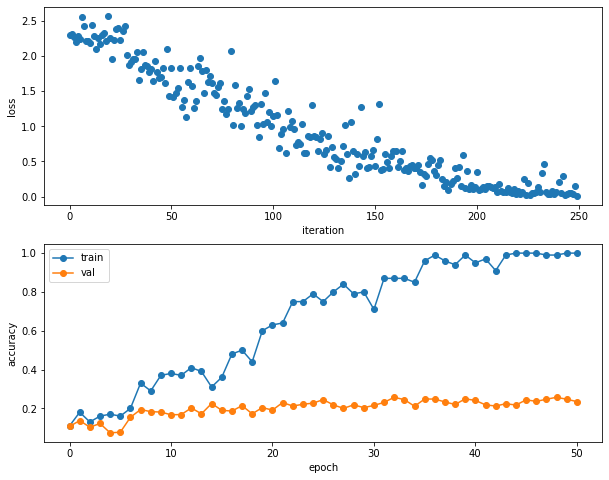

In [30]:
# Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

<font size='4' color='red'>**4.2: Train a good CNN.**
    
<font size='4'>By tweaking different parameters, such as number of convolution layers, learning rate, batch size, etc, you should achieve greater than 62% accuracy on the validation set **with 3 epochs using the sgd_momentum optimizer**.
    
<font size='4'>If you are really careful, you should be able to get nearly 66% accuracy on the validation set. But we don't give extra credits for doing so.
    
<font size='4'>It may take a quite while for your training to be finished. **Do not use more than four convolution layers. Your training shouldn't be longer than one hour.** (This is a rough reference as it depends on the hardware. Our implementation takes less than 10 minutes to finish.)
    
<font size='4'>Use a large filter/kernel size in the first convolution layer (for example, 7), so you can easily visualize the learend filters.
    
<font size='4'>Since it is relatively slower to train a CNN, you can simply report the best hyper parameters you found. You need report validation accuracy of other choices below.

In [32]:
best_model = None

# TODO: Train the best ConvNet that you can on CIFAR-10 with 3 epochs using    
# the sgd_momentum optimizer. Store your best model in the best_model variable.

model = ConvNet(
    num_filters=[32, 64, 128, 128],
    filter_sizes=[7, 3, 3, 3],
    weight_scale=1e-3, reg = 0.001
)

solver = Solver(
    model, data,
    num_epochs=3, batch_size=100,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': 9e-5,
    },
    verbose=True, print_every=20
)
solver.train()

best_model = model

(Iteration 1 / 1470) loss: 2.302478
(Epoch 0 / 3) train acc: 0.095000; val_acc: 0.087000
(Iteration 21 / 1470) loss: 1.920542
(Iteration 41 / 1470) loss: 2.062451
(Iteration 61 / 1470) loss: 1.820759
(Iteration 81 / 1470) loss: 1.816151
(Iteration 101 / 1470) loss: 1.805264
(Iteration 121 / 1470) loss: 1.541790
(Iteration 141 / 1470) loss: 1.672385
(Iteration 161 / 1470) loss: 1.505831
(Iteration 181 / 1470) loss: 1.441737
(Iteration 201 / 1470) loss: 1.595318
(Iteration 221 / 1470) loss: 1.321565
(Iteration 241 / 1470) loss: 1.508716
(Iteration 261 / 1470) loss: 1.433051
(Iteration 281 / 1470) loss: 1.244197
(Iteration 301 / 1470) loss: 1.436477
(Iteration 321 / 1470) loss: 1.382601
(Iteration 341 / 1470) loss: 1.519281
(Iteration 361 / 1470) loss: 1.359016
(Iteration 381 / 1470) loss: 1.348443
(Iteration 401 / 1470) loss: 1.226444
(Iteration 421 / 1470) loss: 1.132174
(Iteration 441 / 1470) loss: 1.189000
(Iteration 461 / 1470) loss: 1.299210
(Iteration 481 / 1470) loss: 1.509460
(Ep

In [33]:
# Run your best model on the validation and test sets. You should achieve above 62% accuracy on the validation set.
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.646
Test set accuracy:  0.616


### Visualize Filters

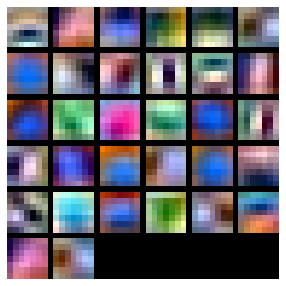

In [35]:
# You can visualize the first-layer convolutional filters from the trained network by running the following:
from utils.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

<font size='4' color='red'>**Task 4.3: report validation accuray for other hyper parameters you have tried**

model = ConvNet(num_filters=[32, 64],filter_sizes=[7, 3],weight_scale=1e-3)
solver = Solver(model, data, num_epochs=3, batch_size=100, update_rule='sgd_momentum', optim_config={'learning_rate': 1e-2,
    },verbose=True, print_every=20)
    
Validation accuracy = ~42%

model = ConvNet(num_filters=[32, 64],filter_sizes=[7, 3],weight_scale=1e-3,reg=0.001)
solver = Solver(model, data, num_epochs=3, batch_size=100, update_rule='sgd_momentum', lr_decay = 0.75, optim_config={'learning_rate': 1e-2,},verbose=True, print_every=20)

Validation accuracy = ~50%

model = ConvNet(num_filters=[32, 64, 64],filter_sizes=[7, 3, 3],weight_scale=1e-3,reg=0.003)
solver = Solver(model, data, num_epochs=3, batch_size=100, update_rule='sgd_momentum', lr_decay = 0.75, optim_config={'learning_rate': 5e-2,},verbose=True, print_every=20)

Validation accuracy = ~54%

model = ConvNet(num_filters=[32, 64, 128],filter_sizes=[7, 3, 3],weight_scale=e-3,reg=0.001)
solver = Solver(model, data, num_epochs=3, batch_size=100, update_rule='sgd_momentum', lr_decay = 0.75, optim_config={'learning_rate': 5e-2,},verbose=True, print_every=20)

Validation accuracy = ~56%

model = ConvNet(num_filters=[32, 64, 128],filter_sizes=[7, 3, 3],weight_scale=e-3,reg=0.003)
solver = Solver(model, data, num_epochs=3, batch_size=100, update_rule='sgd_momentum', lr_decay = 0.75, optim_config={'learning_rate': 7e-2,},verbose=True, print_every=20)

Validation accuracy = ~58%

model = ConvNet(num_filters=[32, 64, 128, 128],filter_sizes=[7, 3, 3, 3],weight_scale=e-3,reg=0.003)
solver = Solver(model, data, num_epochs=3, batch_size=100, update_rule='sgd_momentum', lr_decay = 0.75, optim_config={'learning_rate': 7e-2,},verbose=True, print_every=20)

Validation accuracy = ~61%


<font size='4' color='red'>**Task 4.4: train a ConvNet without using batch normalization layers.**
    
<font size='4'>Report the best validation accuracy you can get and discuss how it is different from the version with batch normalization layers.
    
Without using batch normalization layers, validation accuracy fell down to 8.6% as compared to model with same hyperparameters having batch normalization layers and validation accuracy of 64.6%. Using batch normalization, we add a normalization step that fixes the means and variances of layer inputs which helps in faster convergence and improved gradient flow through the network, by reducing the dependence of gradients on the scale of the parameters or of their initial values. Without batch normalization, the model accuracy drops by a huge margin. 

In [36]:
wb_model = ConvNet(
    num_filters=[32, 64, 128, 128],
    filter_sizes=[7, 3, 3, 3],
    weight_scale=1e-3, reg = 0.001, use_batch_norm = False
)

solver = Solver(
    wb_model, data,
    num_epochs=3, batch_size=100,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': 8e-2,
    },
    verbose=True, print_every=20
)
solver.train()

(Iteration 1 / 1470) loss: 2.302708
(Epoch 0 / 3) train acc: 0.090000; val_acc: 0.102000
(Iteration 21 / 1470) loss: 2.305453
(Iteration 41 / 1470) loss: 2.306723
(Iteration 61 / 1470) loss: 2.307407
(Iteration 81 / 1470) loss: 2.302867
(Iteration 101 / 1470) loss: 2.309045
(Iteration 121 / 1470) loss: 2.302799
(Iteration 141 / 1470) loss: 2.300178
(Iteration 161 / 1470) loss: 2.300401
(Iteration 181 / 1470) loss: 2.303839
(Iteration 201 / 1470) loss: 2.307089
(Iteration 221 / 1470) loss: 2.318188
(Iteration 241 / 1470) loss: 2.307918
(Iteration 261 / 1470) loss: 2.297863
(Iteration 281 / 1470) loss: 2.314662
(Iteration 301 / 1470) loss: 2.304033
(Iteration 321 / 1470) loss: 2.308585
(Iteration 341 / 1470) loss: 2.311354
(Iteration 361 / 1470) loss: 2.300686
(Iteration 381 / 1470) loss: 2.308401
(Iteration 401 / 1470) loss: 2.303230
(Iteration 421 / 1470) loss: 2.303243
(Iteration 441 / 1470) loss: 2.297680
(Iteration 461 / 1470) loss: 2.300807
(Iteration 481 / 1470) loss: 2.303534
(Ep